In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

import re
import string
from unidecode import unidecode
import emoji

# import torchtext.vocab
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize, TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Test

In [104]:
file_test = 'test_spam.csv'

data_test = pd.read_csv(file_test)
data_test.head()

,text
0,j jim whitehead ejw cse ucsc edu writes j you ...
1,original message from bitbitch magnesium net p...
2,java for managers vince durasoft who just taug...
3,there is a youtuber name saiman says
4,underpriced issue with high return on equity t...


In [105]:
data_test.shape

(4070, 1)

In [106]:
data_test.iloc[0, 0]

'j jim whitehead ejw cse ucsc edu writes j you open sourced the new components you developed for this j project so the next person who comes along won t have to j reimplement them right no need all those components already exist either in the java class libraries or from the various java jar collections most of the classes i used came from the jakarta project and apachexml but if it s any consolation my threading of them all together into a newswire server is gpl and available on sourceforge gary lawrence murphy garym teledyn com teledynamics communications inc business advantage through community software url computers are useless they can only give you answers pablo picasso'

### Train

In [107]:
file_train = 'train_spam.csv'

data_train = pd.read_csv(file_train)
data_train.head()

,text_type,text
0,ham,make sure alex knows his birthday is over in f...
1,ham,a resume for john lavorato thanks vince i will...
2,spam,plzz visit my website moviesgodml to get all m...
3,spam,urgent your mobile number has been awarded wit...
4,ham,overview of hr associates analyst project per ...


In [108]:
data_train.shape

(16278, 2)

In [109]:
data_train.iloc[0, 1]

'make sure alex knows his birthday is over in fifteen minutes as far as youre concerned'

## Базовая аналитика

In [110]:
number_of_ham = sum(data_train['text_type'] == 'ham')
number_of_spam = sum(data_train['text_type'] == 'spam')

print(f"Число нормальных сообщений: {number_of_ham}")
print(f"Число спама: {number_of_spam}")

Число нормальных сообщений: 11469
Число спама: 4809


Классы несбалансированы, но для оценки качества используется ROC AUC, который нечуствителен к дисбалансу. Поэтому каких-то дополнительных действий для борьбы с влиянием дисбаланса при подготовке данных и при обучении моделей делать не буду.

In [111]:
print(f'Точность константного классификатора {number_of_ham/(number_of_ham + number_of_spam):.3f}')

Точность константного классификатора 0.705


In [112]:
data_ham = data_train[data_train['text_type'] == 'ham']
data_spam = data_train[data_train['text_type'] == 'spam']

In [221]:
texts_ham = data_ham['text'].to_list()
texts_ham[-40:]

['whnevr an unexpected joy passes thru ur heart n suddenly u smile 4 no reason remembr sm1 smwhere is remembring appreciating ur good deeds help people:',
 'your advice is appreciated vince in the morning we were talking about the el paso candidate who thinks he is above something and is not willing to take certain project or responsibility in real life we also occasionally have similar stiuation an example is attached i would like to have your guidance when such a situation occurs ziminforwarded by zimin lu hou ect on 05 02 2001 02 07 pm zimin lu 05 02 2001 01 41 pm to paulo issler hou ect ect cc subject asian option for pavel our convention is whoever finalizes the model should write the documentation it does not make sense to write one when changes are anticipated you have been working on this almost a year it never strikes you that we need a document',
 'the research lunch i would be very willing to make a presentation to you this coming thursday unfortunately i have a sick day sch

In [115]:
texts_spam = data_spam['text'].to_list()
texts_spam[-40:]

['still paying too much for life insurance u save up to 75 on your term life insurance compare rates from top insurance companies around the country in our life and times it s important to plan for your family s future while being comfortable financially choose the right life insurance policy today click the link below to compare the lowest rates and save up to 75 compare your coverage you ll be able to compare rates and get a free application in less than a minute get your free instant quotes compare the lowest prices then select a company and apply online get a free quote now you can t predict the future but you can always prepare for it to be excluded from future contacts kanz http xent com mailman listinfo fork',
 'ɪ ɪɴᴠᴇꜱᴛᴇᴅ $300 ᴅᴏʟʟᴀʀꜱ ᴀɴᴅ ʀᴇᴄᴇɪᴠᴇ $3000 ᴅᴏʟʟᴀʀꜱ ᴛᴏᴅᴀʏ ꜰʀᴏᴍ ᴛʜɪꜱ ʙɪɴᴀʀʏ ᴘʟᴀᴛꜰᴏʀᴍ ᴛʜɪꜱbᴄᴏᴍᴘᴀɴʏ ɪꜱ ᴛʀᴜꜱᴛᴇᴅ ɪɴᴠᴇꜱᴛ ᴡɪᴛʜ ᴛʜᴇᴍ ᴀɴᴅ ꜰᴏʀɢᴇᴛ ᴀʙᴏᴜᴛ ᴅᴏᴇꜱ ꜰᴀᴋᴇ ᴄᴏᴍᴘᴀɴɪᴇꜱ 🇺🇸🇩🇪🇪🇦🇨🇳🇨🇭🇫🇰🇬🇧🇨🇵🇨🇮🇨🇺🇧🇷🇧🇪 👇👇👇👇👇 @fxshawnjsinek01 @joinchat2ptgu5bdx1tlogm0 @joinchat2ptgu5bdx1tlogm0 @joinchat2p

Тексты в основном приведены к низкому регистру и лишены пунктуации. Однако, и для регистра, и для пунктуации есть исключения.

В спаме часто встречаются эмоджи и текст написанный другими нестандартными шрифтами.

### Распределение длин сообщений в символах


Ham min max 1 800
Spam min max 5 800


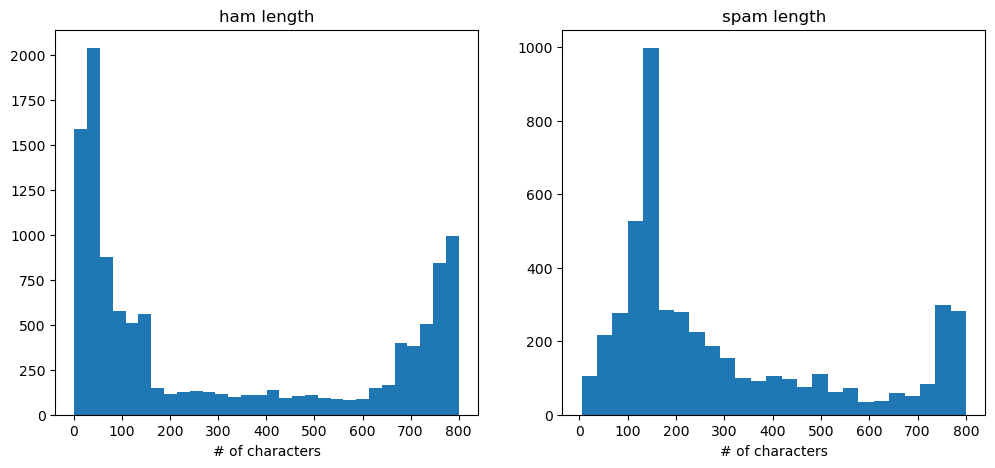

In [116]:
ham_len = list(map(len, list(texts_ham)))
spam_len = list(map(len, list(texts_spam)))
print('Ham min max', np.min(ham_len), np.max(ham_len))
print('Spam min max', np.min(spam_len), np.max(spam_len))


plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("ham length")
plt.hist(ham_len, bins=30)
plt.xlabel('# of characters')

plt.subplot(1, 2, 2)
plt.title("spam length")
plt.hist(spam_len, bins=25)
plt.xlabel('# of characters')

plt.show()

### Переводим в токены

In [135]:
lemmatizer = WordNetLemmatizer()

tokenizer = TweetTokenizer()

ENGLISH_STOP_WORDS = set(stopwords.words('english'))

In [233]:
def to_lower(words):
    result = words.lower()
    return result


def remove_underscore(words):
    return re.sub(r'_', ' ', words)

def remove_punctuation(words):
    result = re.sub(r'[!"#%&\'()*+,-./:;<=>?@\[\]^`{|}~]', ' ', words) # everything except underscore and $
    return result


def replace_hyperlink(words, replace=' <HTTP> '):
    return re.sub(r'http(?:\S*|\b)', replace, words)

def remove_hyperlink(words):
    return replace_hyperlink(words, '')


def emoji_to_text(words):
    return emoji.demojize(words)

def replace_emoji(words,  replace=' <EMOJI> '):
    return emoji.replace_emoji(words, replace=replace)

def remove_emoji(words):
    return replace_emoji(words, '')


def replace_non_ascii_words(words, replace=' <NONASCII> '):
    pattern = r'\b[^\x00-\x7F]+\b'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def replace_non_ascii(words, replace=' <NONASCII> '):
    pattern = r'[^\x00-\x7F]'
    non_ascii_words = re.sub(pattern, replace, words)
    return non_ascii_words

def remove_non_ascii(words):
    # return words.encode('ascii', errors='ignore').decode('ascii')
    return unidecode(words)


def replace_number(words, replace=' <NUMBER> '):
    result = re.sub(r'\b\w*\d\w*\b', replace, words)
    return result

def remove_number(words):
    return replace_number(words, '')


def replace_currency(words, replace=' <CURRENCY> '):
    currency_pattern = r'[£$€₹]'
    return re.sub(currency_pattern, replace, words)

def remove_currency(words):
    return replace_currency(words, '')


def remove_whitespace(words):
    return words.strip()

def replace_newline(words):
    return words.replace('\n', ' ')

def remove_stop_words(words):
    return [i for i in words if i not in ENGLISH_STOP_WORDS]

def word_lemmatizer(words):
    return [lemmatizer.lemmatize(s) for s in words]

In [223]:
def preprocess_pipeline(sentence, preprocess_utils=None):
    if preprocess_utils is None:
        preprocess_utils = [
            to_lower,
            replace_newline,
            remove_underscore,
            replace_hyperlink,
            replace_emoji,
            replace_non_ascii_words,
            replace_non_ascii,
            remove_non_ascii,
            remove_punctuation,
            remove_whitespace,
            tokenizer.tokenize,
            remove_stop_words,
            word_lemmatizer,
        ]
    for func in preprocess_utils:
        sentence = func(sentence)
    return sentence

In [234]:
preprocess_utils = [
    to_lower,
    replace_newline,
    remove_underscore,
    replace_hyperlink,
    replace_currency,
    replace_emoji,
    replace_non_ascii_words,
    replace_non_ascii,
    remove_non_ascii,
    replace_number,
    remove_punctuation,
    remove_whitespace,
    tokenizer.tokenize,
    remove_stop_words,
    word_lemmatizer,
]


texts_ham_tokenized = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_ham
]

texts_spam_tokenized = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_spam
]

Ham min max 0 149
Spam min max 1 242


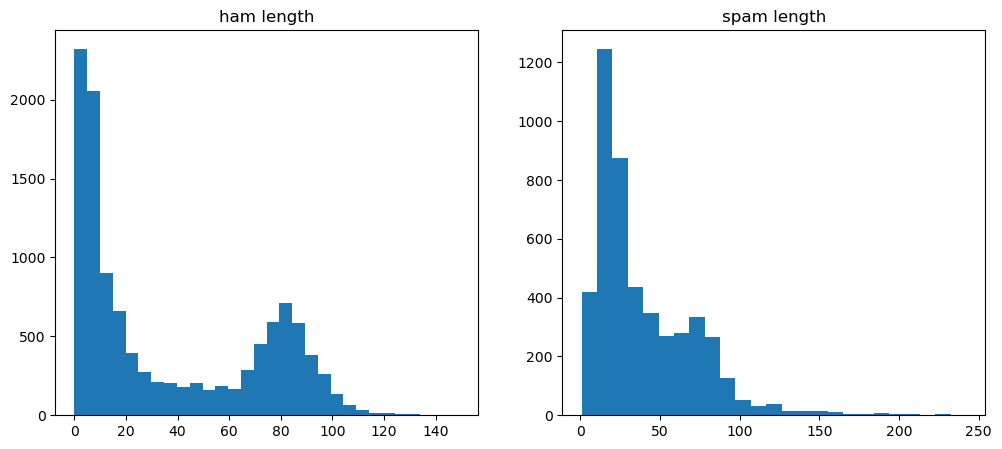

In [235]:
ham_len = list(map(len, texts_ham_tokenized))
spam_len = list(map(len, texts_spam_tokenized))
print('Ham min max', np.min(ham_len), np.max(ham_len))
print('Spam min max', np.min(spam_len), np.max(spam_len))


plt.figure(figsize=[12, 5])

plt.subplot(1, 2, 1)
plt.title("ham length")
plt.hist(ham_len, bins=30)

plt.subplot(1, 2, 2)
plt.title("spam length")
plt.hist(spam_len, bins=25)

plt.show()

## Word cloud plots

In [204]:
def plot_wordcloud(tokenized_text, mask=None, max_words=200, max_font_size=100, figure_size=(15, 10),
                   title = None, title_size=40, image_color=False):
    stopwords = set(STOPWORDS)
    more_stopwords = {'one', 'br', 'Po', 'th', 'sayi', 'fo', 'Unknown'}
    stopwords = stopwords.union(more_stopwords)
    
    text_strings = [' '.join(s) for s in tokenized_text]
    text = ' '.join(text_strings)

    wordcloud = WordCloud(background_color='black',
                    stopwords = stopwords,
                    max_words = max_words,
                    max_font_size = max_font_size, 
                    random_state = 42,
                    width=800, 
                    height=400,
                    mask = mask)
    wordcloud.generate(text)
    
    plt.figure(figsize=figure_size)
    plt.imshow(wordcloud)
    plt.title(title, fontdict={'size': title_size, 'color': 'black',
                                'verticalalignment': 'bottom'})
    plt.axis('off')
    plt.tight_layout()
    plt.show()

Уберем все числа, знаки валют, эмоджи. Приведем к ASCII нестандартные символы. Это нужно, чтобы эти keywords не забивали другие слова.

In [205]:
preprocess_utils = [
    to_lower,
    replace_newline,
    remove_underscore,
    remove_hyperlink,
    remove_currency,
    remove_number,
    remove_emoji,
    unidecode,
    remove_punctuation,
    remove_whitespace,
    tokenizer.tokenize,
    remove_stop_words,
    word_lemmatizer,
]


texts_ham_tokenized_2 = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_ham
]

texts_spam_tokenized_2 = [
    preprocess_pipeline(sent, preprocess_utils) for sent in texts_spam
]

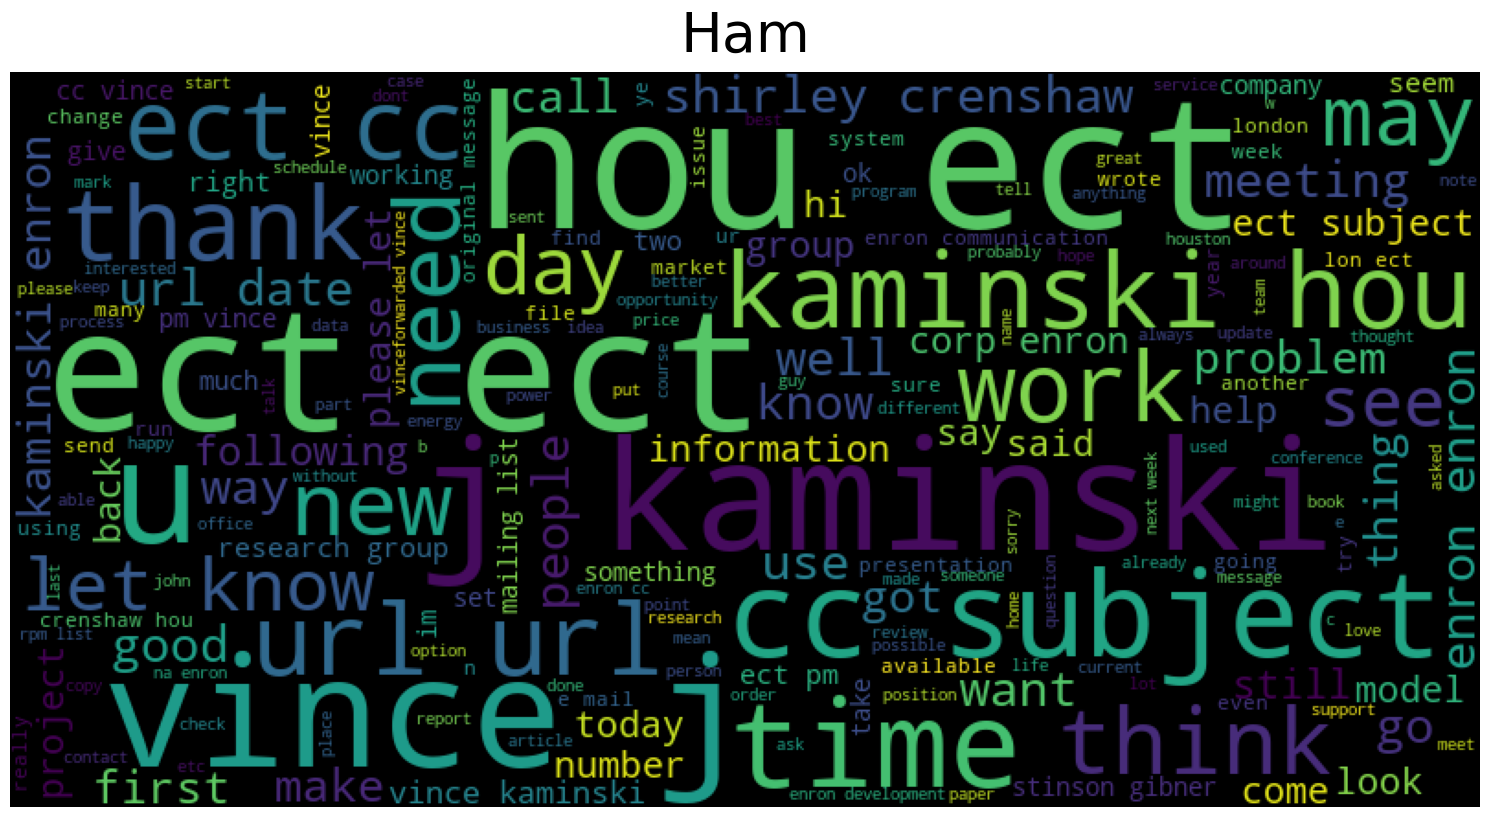

In [206]:
plot_wordcloud(texts_ham_tokenized_2, title='Ham')

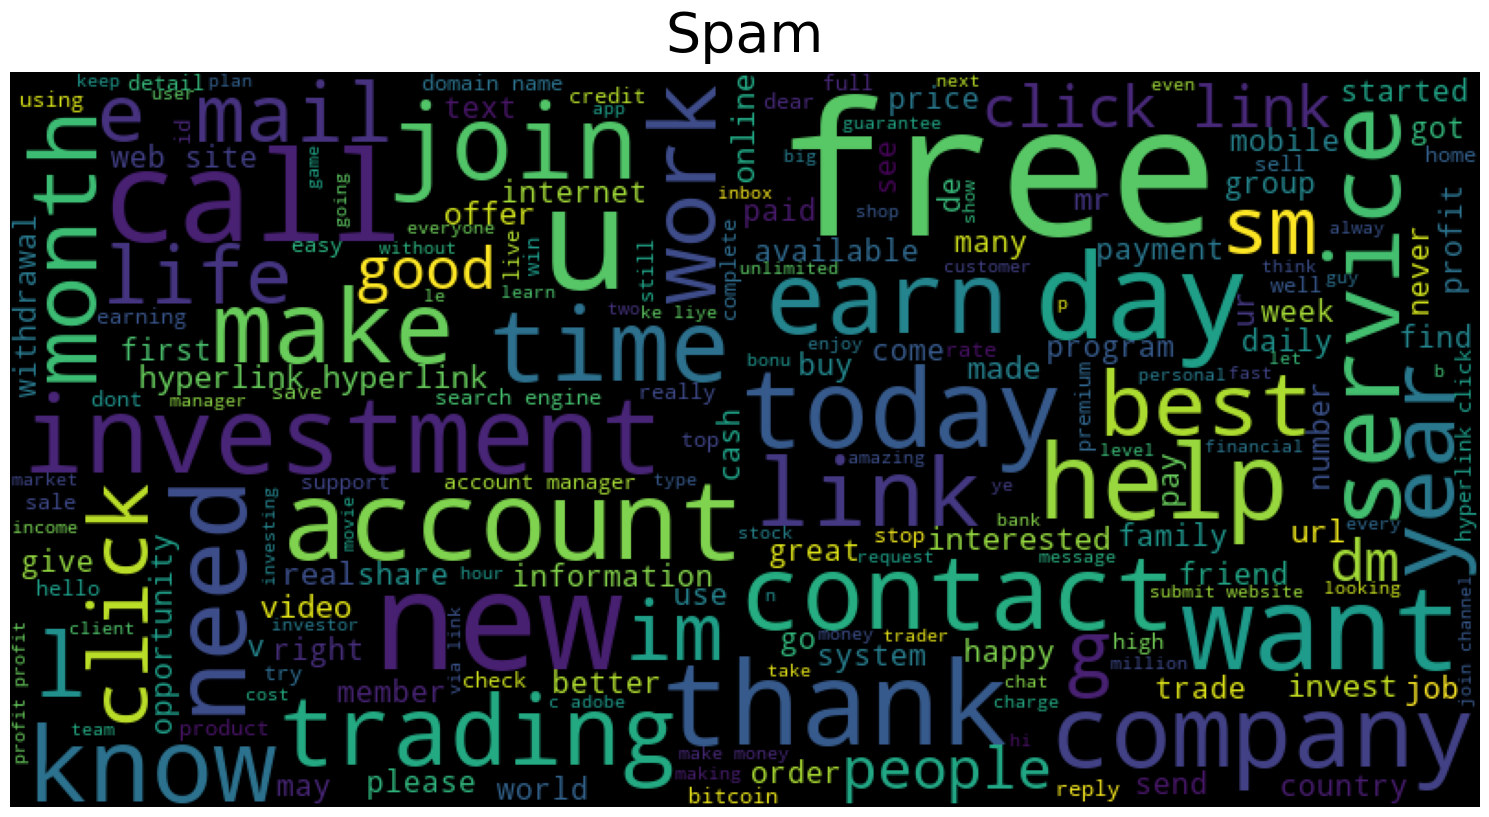

In [207]:
plot_wordcloud(texts_spam_tokenized_2, title='Spam')

## Построим словари и выведем наиболее частые слова

In [236]:
def build_vocab(tokenized_sentences):
    counter = Counter()
    for sentence in tokenized_sentences:
        counter.update(sentence)
    return counter

In [237]:
ham_vocab = build_vocab(texts_ham_tokenized)
print(f'Len of ham vocab {len(ham_vocab)}')

spam_vocab = build_vocab(texts_spam_tokenized)
print(f'Len of spam vocab {len(spam_vocab)}')

Len of ham vocab 28413
Len of spam vocab 17460


In [259]:
top_n = 30

top_ham_words = ham_vocab.most_common(top_n)

for word, count in top_ham_words:
    print(f"{word}: {count} {count/number_of_ham:.4f}")

NUMBER: 42804 3.7321
ect: 5344 0.4660
enron: 4848 0.4227
vince: 4525 0.3945
url: 3624 0.3160
hou: 2660 0.2319
kaminski: 2365 0.2062
subject: 2114 0.1843
u: 2112 0.1841
j: 1931 0.1684
cc: 1909 0.1664
please: 1888 0.1646
com: 1852 0.1615
would: 1850 0.1613
pm: 1821 0.1588
time: 1569 0.1368
like: 1440 0.1256
get: 1417 0.1236
thanks: 1407 0.1227
know: 1389 0.1211
group: 1220 0.1064
message: 1198 0.1045
one: 1165 0.1016
list: 1079 0.0941
new: 1012 0.0882
research: 1010 0.0881
date: 973 0.0848
need: 967 0.0843
day: 910 0.0793
work: 905 0.0789


In [260]:
top_n = 30
top_spam_words = spam_vocab.most_common(top_n)

for word, count in top_spam_words:
    print(f"{word}: {count} {count/number_of_spam:.4f}")

NONASCII: 24949 5.1880
NUMBER: 18441 3.8347
EMOJI: 11632 2.4188
CURRENCY: 1305 0.2714
free: 1087 0.2260
get: 883 0.1836
u: 610 0.1268
r: 604 0.1256
call: 581 0.1208
new: 570 0.1185
click: 557 0.1158
link: 545 0.1133
account: 507 0.1054
one: 499 0.1038
offer: 487 0.1013
company: 481 0.1000
money: 481 0.1000
com: 479 0.0996
time: 474 0.0986
please: 470 0.0977
day: 461 0.0959
business: 441 0.0917
want: 440 0.0915
make: 430 0.0894
best: 428 0.0890
email: 423 0.0880
like: 404 0.0840
price: 401 0.0834
need: 392 0.0815
hyperlink: 390 0.0811


### Посмотрим на уникальные слова

In [245]:
ham_words = set(ham_vocab.keys())
spam_words = set(spam_vocab.keys())

ham_unique_words = ham_words.difference(spam_words)
spam_unique_words = spam_words.difference(ham_words)

ham_unique_words_counter = Counter(dict([(word, ham_vocab[word]) for word in ham_unique_words]))
spam_unique_words_counter = Counter(dict([(word, spam_vocab[word]) for word in spam_unique_words]))


In [264]:
top_n = 10
top_unique_ham_words = ham_unique_words_counter.most_common(top_n)

print('Уникальные в ham:\n')
for word, count in top_unique_ham_words:
    print(f"{word}: {count} {count/number_of_ham:.4f}")

Уникальные в ham

enron: 4848 0.4227
kaminski: 2365 0.2062
stinson: 565 0.0493
crenshaw: 556 0.0485
rpm: 508 0.0443
gibner: 325 0.0283
rice: 310 0.0270
zimin: 282 0.0246
razor: 257 0.0224
eb: 245 0.0214


In [265]:
top_n = 10
top_unique_spam_words = spam_unique_words_counter.most_common(top_n)

print('Уникальные в spam:\n')
for word, count in top_unique_spam_words:
    print(f"{word}: {count} {count/number_of_spam:.4f}")

Уникальные в spam:

follower: 106 0.0220
stationery: 92 0.0191
viagra: 91 0.0189
investing: 75 0.0156
noida: 68 0.0141
andmanyother: 67 0.0139
macromedia: 65 0.0135
forex: 61 0.0127
blyk: 57 0.0119
talktime: 56 0.0116


### Посмотрим на общие слова

In [262]:
shared_words = ham_words.intersection(spam_words)
print(f'Number of shared words {len(shared_words)}')

shared_words_ham_counter = Counter(dict([(word, ham_vocab[word]) for word in shared_words]))
shared_words_spam_counter = Counter(dict([(word, spam_vocab[word]) for word in shared_words]))

Number of shared words 7754


Видно, что словари не очень сильно пересекаются.

In [252]:
top_n = 20
top_shared_ham_words = shared_words_ham_counter.most_common(top_n)

for word, count in top_shared_ham_words:
    print(f"{word}: {count} {count/number_of_ham:.4f}")

NUMBER: 42804 3.7321
ect: 5344 0.4660
vince: 4525 0.3945
url: 3624 0.3160
hou: 2660 0.2319
subject: 2114 0.1843
u: 2112 0.1841
j: 1931 0.1684
cc: 1909 0.1664
please: 1888 0.1646
com: 1852 0.1615
would: 1850 0.1613
pm: 1821 0.1588
time: 1569 0.1368
like: 1440 0.1256
get: 1417 0.1236
thanks: 1407 0.1227
know: 1389 0.1211
group: 1220 0.1064
message: 1198 0.1045


In [253]:
top_n = 20
top_shared_spam_words = shared_words_spam_counter.most_common(top_n)

for word, count in top_shared_spam_words:
    print(f"{word}: {count} {count/number_of_spam:.4f}")

NONASCII: 24949 5.1880
NUMBER: 18441 3.8347
EMOJI: 11632 2.4188
CURRENCY: 1305 0.2714
free: 1087 0.2260
get: 883 0.1836
u: 610 0.1268
r: 604 0.1256
call: 581 0.1208
new: 570 0.1185
click: 557 0.1158
link: 545 0.1133
account: 507 0.1054
one: 499 0.1038
offer: 487 0.1013
money: 481 0.1000
company: 481 0.1000
com: 479 0.0996
time: 474 0.0986
please: 470 0.0977


Размер общего словаря

In [261]:
joined_words = ham_words.union(spam_words)
print(len(joined_words))

38119


В качестве эмпирических признаков, можно брать слова, которые достаточно часто встречаются либо в спаме, либо в хаме. Их можно отбирать по среднему числу слова в предложении, т.е. count / number_of_spam или  count / number_of_ham.

## Частота хэштегов, собак, знаков экскламации и т.д.

In [254]:
def count_http(texts):
    counts = []
    for text in texts:
        count = text.count('http')
        counts.append(count)
    return counts

In [255]:
def count_all_punctuation(texts, n):
    for s in string.punctuation:
        count = 0
        for text in texts:
            count += text.count(s)
        if count > 0:
            print(f'{s} {count} {count/n:.3f}')

In [256]:
print('Ham')
count_all_punctuation(texts_ham, number_of_ham)

Ham
! 382 0.033
$ 15 0.001
% 7 0.001
& 8 0.001
+ 5 0.000
- 11 0.001
. 11 0.001
/ 108 0.009
: 515 0.045
? 528 0.046
@ 103 0.009
[ 11 0.001
] 11 0.001


In [257]:
print('Spam')
count_all_punctuation(texts_spam, number_of_spam)

Spam
! 640 0.133
$ 759 0.158
& 54 0.011
+ 47 0.010
/ 864 0.180
: 565 0.117
? 289 0.060
@ 736 0.153


In [258]:
print('http')
ham_http_counts = count_http(texts_ham)
print('Ham', np.sum(ham_http_counts), np.sum(ham_http_counts)/number_of_ham)

spam_http_counts = count_http(texts_spam)
print('Spam', np.sum(spam_http_counts), np.sum(spam_http_counts)/number_of_spam)

http
Ham 251 0.021885081524108466
Spam 322 0.06695778748180495


Следовательно, стоит добавить в признаки информацию о !, /, :, ?, @ и http.